## AST 5371

Claudia Scarlata


### Censored Models


### PyMC resources

[Old PyMC3 tutorial](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-truncated-censored-regression.html)

[Plot_trace in depth](https://oriolabril.github.io/oriol_unraveled/python/arviz/matplotlib/2020/06/20/plot-trace.html)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats
from numpy.random import default_rng


#the following function censors a datasets. Useful for simulations

def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

rng = default_rng(12345)
slope, intercept, σ, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=σ)


To model a linear regression including right censored data, we use different likelihood for the measured pints and for the censored data. For the measured data, we use the usual Normal: 

$$
p(y|x,\beta,\sigma) \sim N(\beta x,\sigma)
$$

For right-censored data points, the likelihood can be computed as:

$$
p(y>u|x,\beta,\sigma,u) = \int_u^{\infty} Normal(y|\beta x,\sigma)dy = 1 - \Phi(\frac{u-\beta x}{\sigma})
$$

where $\Phi$ is the Normal cumulative distribution function (CDF).

With M censored observations, the total probability on the log scale is:

$$
\log \prod_{m=1}^Mp(y_m>u|x,\beta,\sigma,u) = \log{\left(1 - \Phi(\frac{u-\beta x}{\sigma})\right)^M} = M\times \rm normal\_lccdf(u|x,\beta,\sigma)
$$

where normal_lccdf is the log of the complementary CDF.

For left-censored data points, the likelihood is similar. 

In PyMC this model can be implemented as in the next two cells. 

Note: 

- Similar to what was done in R, we need to do some preprocessing of the data. Specifically, we need to divide the full sample in uncensored, left and right censored.
- Note the use of pm.Potential, which adds arbitrary functions to the log(likelihood). Here, we are adding the normal_lcdf(or normal_lccdf) which is a function of x_lc,slope,intercept,σ, y_lc. Potential will add this function to the log(likelihood). [normal_lcdf is the normal cumulative density function].

In [2]:
import pymc as pm
import xarray as xr

from pymc.distributions.dist_math import normal_lccdf, normal_lcdf
from scipy.stats import norm, truncnorm
from copy import copy


In [3]:

def censored_regression(xx, yy, bounds):

    # data pre-processing
    left_censored = yy <= bounds[0]  # <= rather than == for numerical safety
    x_lc = xx[left_censored]
    y_lc = yy[left_censored]

    right_censored = y >= bounds[1]  # >= rather than == for numerical safety
    x_rc = xx[right_censored]
    y_rc = yy[right_censored]

    uncensored = (yy > bounds[0]) & (yy < bounds[1])

    xu = xx[uncensored]
    yu = yy[uncensored]

    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * xu + intercept, sigma=σ, observed=yu)
        left_censored = pm.Potential(
            "left_censored", normal_lcdf(slope * x_lc + intercept, σ, y_lc)
        )
        right_censored = pm.Potential(
            "right_censored", normal_lccdf(slope * x_rc + intercept, σ, y_rc)
        )

    return model



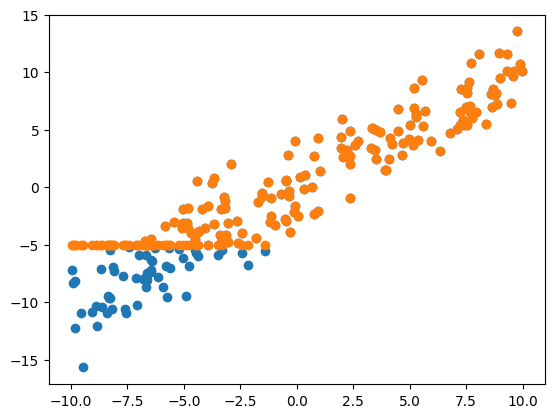

In [4]:
bounds = [-5, 15]
xc, yc = censor_y(x, y, bounds)
plt.scatter(x,y)
plt.scatter(xc,yc)


In [5]:
censored_model = censored_regression(xc, yc, bounds)

with censored_model:
    censored_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [13]:
with pm.Model() as model:
    slope = pm.Normal("slope", mu=0, sigma=1)
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    y_obs = pm.Normal("y_obs", mu=slope * xc + intercept, sigma=σ, observed=yc)
    wrong_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


[Text(0.5, 1.0, 'Linear regression\n(censored data)'), Text(0.5, 0, 'slope')]

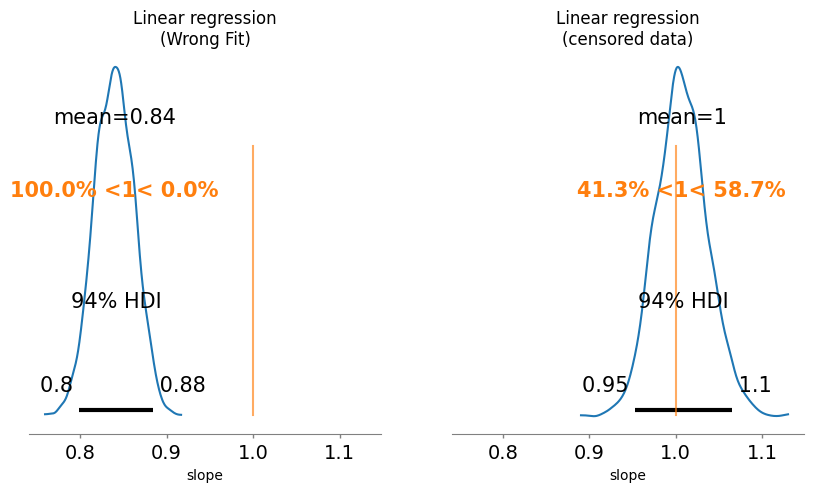

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(wrong_fit, var_names=["slope"], ref_val=1, ax=ax[0])
ax[0].set(title="Linear regression\n(Wrong Fit)", xlabel="slope")

az.plot_posterior(censored_fit, var_names=["slope"], ref_val=1, ax=ax[1])
ax[1].set(title="Linear regression\n(censored data)", xlabel="slope")

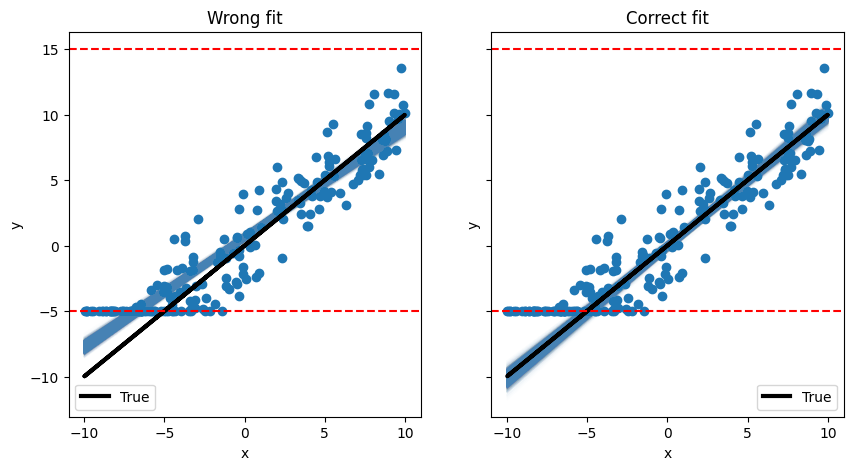

In [22]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    # plot true
    if true:
        ax.plot(xx, xx , "k", lw=3, label="True")
    # plot bounds
    ax.axhline(bounds[0], c="r", ls="--")
    ax.axhline(bounds[1], c="r", ls="--")
    ax.legend()
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(xc, yc)

pp_plot(xc, yc, wrong_fit, ax[0],true=True)
ax[0].set(title="Wrong fit")

ax[1].scatter(xc, yc)
pp_plot(xc, yc, censored_fit, ax[1],true=True)
ax[1].set(title="Correct fit");

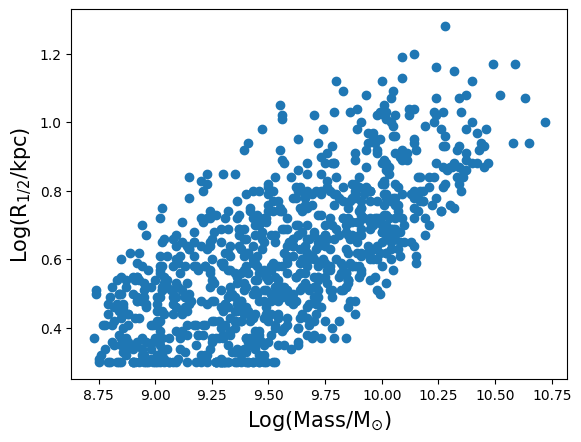

In [23]:
data = pd.read_csv('LogMLogR.csv')
data


plt.scatter(data['Log_Mass'],data['Log_Rad'])
plt.xlabel(r'Log(Mass/M$_{\odot}$)',fontsize=15)
plt.ylabel(r'Log(R$_{1/2}$/kpc)',fontsize=15)

xc = data['Log_Mass'].values -9.75
yc = data['Log_Rad'].values

In [24]:

def left_censored_regression(x, y, bound):

    # data pre-processing
    left_censored = y <= bound  # <= rather than == for numerical safety
    x_lc = x[left_censored]
    y_lc = y[left_censored]

    uncensored = (y > bounds[0]) & (y < bounds[1])

    x = x[uncensored]
    y = y[uncensored]

    with pm.Model() as model:
        slope = pm.Normal("slope", mu=1, sigma=2)
        intercept = pm.Normal("intercept", mu=-2, sigma=1)
        σ = pm.HalfNormal("σ", sigma=2)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=σ, observed=y)
        left_censored = pm.Potential(
            "left_censored", normal_lcdf(slope * x_lc + intercept, σ, y_lc)
        )

    return model

lc_censored_model = left_censored_regression(xc, yc, 0.3)

with lc_censored_model:
    lc_censored_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


[Text(0.5, 1.0, 'Linear regression\n(censored data)'),
 Text(0.5, 0, 'Intercept')]

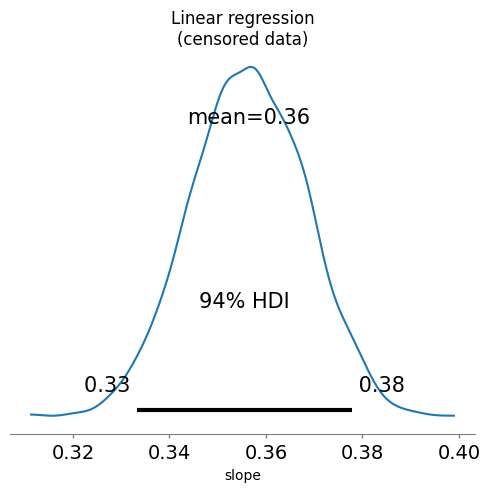

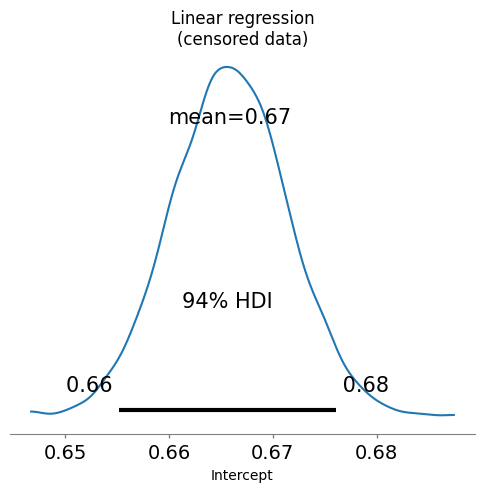

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True)

az.plot_posterior(lc_censored_fit, var_names=["slope"],ax=ax)
ax.set(title="Linear regression\n(censored data)", xlabel="slope")

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True)

az.plot_posterior(lc_censored_fit, var_names=["intercept"],ax=ax)
ax.set(title="Linear regression\n(censored data)", xlabel="Intercept")

In [26]:
az.summary(lc_censored_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.356,0.012,0.333,0.378,0.0,0.0,4107.0,3138.0,1.0
intercept,0.666,0.006,0.655,0.676,0.0,0.0,4094.0,3193.0,1.0
σ,0.159,0.004,0.152,0.166,0.0,0.0,5651.0,3135.0,1.0


array([[<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>],
       [<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>]], dtype=object)

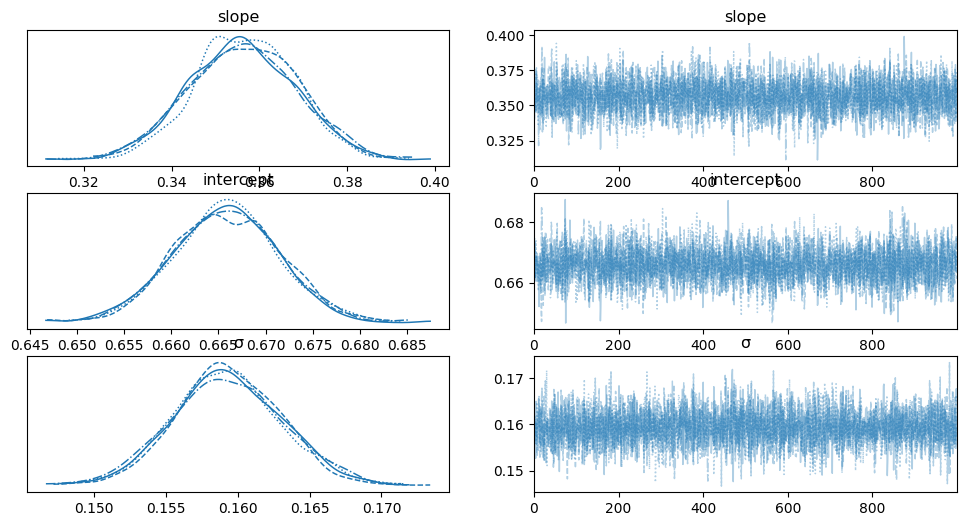

In [27]:
az.plot_trace(lc_censored_fit)

In [28]:
with pm.Model() as model:
    slope = pm.Normal("slope", mu=0, sigma=1)
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    y = pm.Normal("y", mu=slope * xc + intercept, sigma=σ, observed=yc)
    wrong_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [29]:
az.summary(wrong_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.330,0.011,0.308,0.351,0.0,0.0,4176.0,3043.0,1.0
intercept,0.676,0.005,0.666,0.685,0.0,0.0,4103.0,3186.0,1.0
σ,0.150,0.003,0.143,0.156,0.0,0.0,5171.0,2778.0,1.0
